In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN

from src.pipelines import get_iris_pipeline
from src.metrics import get_scores

from configurations.knn_configurations import default_configuration, parameter_grid

In [141]:
data = pd.read_pickle('../data/raw/iris.pkl')

## Uruchomienie KNN

In [142]:
X, y = data.drop(columns=['class']), data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [143]:
pipeline = get_iris_pipeline()
pipeline.steps.append(['clf', KNN()])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

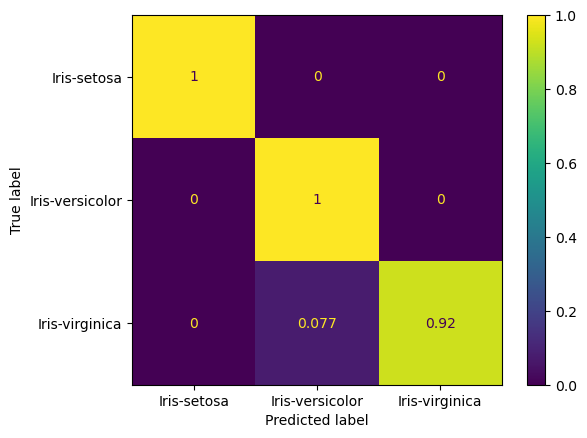

In [144]:
cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
_ = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipeline.classes_,
).plot()
plt.savefig('../figures/iris_cm.png')

In [145]:
get_scores(y_test, y_pred)

{'accuracy': 0.9666666666666667,
 'precision': 0.9629629629629629,
 'recall': 0.9743589743589745,
 'f1': 0.9670588235294119}

## Walidacja krzyżowa

In [146]:
folds = [2, 5, 10]

k_folds_test_log = {}
for k in folds:
    k_folds_test_log[k] = cross_validate(pipeline, X, y, cv=k, scoring='f1_macro')['test_score']

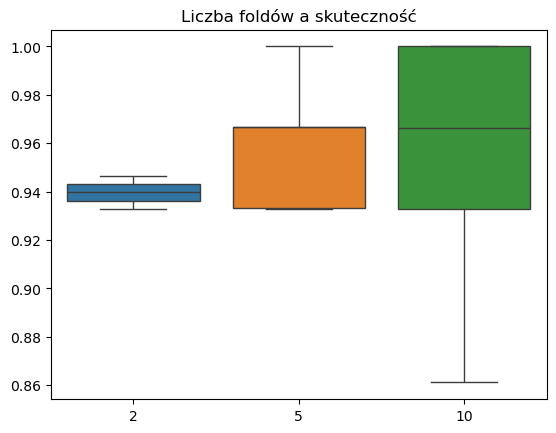

In [147]:
_ = sns.boxplot(k_folds_test_log)
_ = plt.title('Liczba foldów a skuteczność')

## Sprawdzenie różnych wartości parametrów

In [148]:
search = GridSearchCV(pipeline, parameter_grid, cv=5, scoring='f1_macro')
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ['clf', KNeighborsClassifier()]]),
             param_grid={'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [149]:
search.best_params_

{'clf__metric': 'euclidean', 'clf__n_neighbors': 7, 'clf__weights': 'uniform'}

In [150]:
grid_search_results = pd.DataFrame(search.cv_results_)

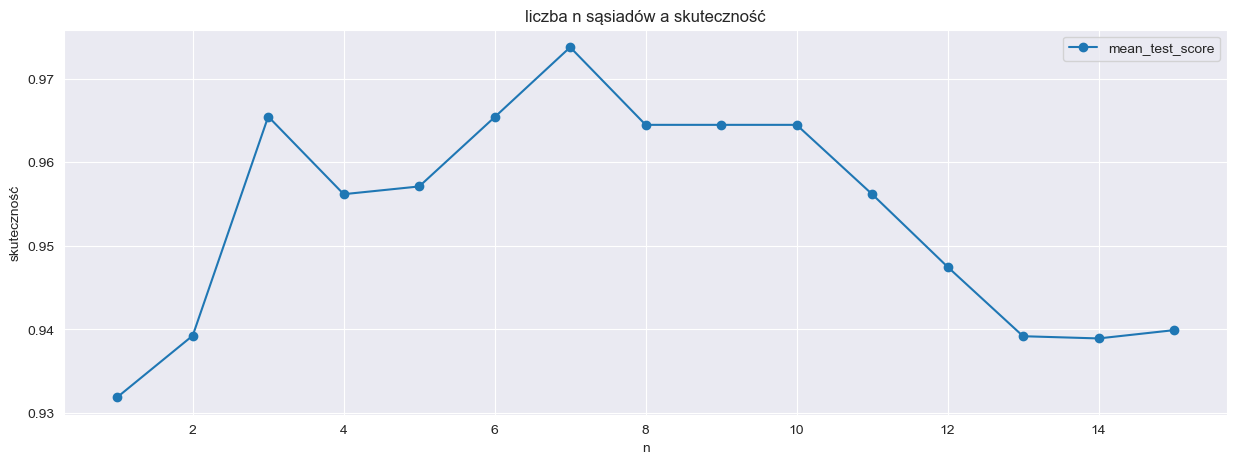

In [151]:
n_neighbors_stats = grid_search_results[(grid_search_results['param_clf__metric'] == default_configuration['clf__metric']) & (grid_search_results['param_clf__weights'] == default_configuration['clf__weights'])]

_ = n_neighbors_stats.plot(
    x='param_clf__n_neighbors',
    y=['mean_test_score'],
    figsize=(15, 5),
    grid=True,
    marker='o',
    xlabel='n',
    ylabel='skuteczność',
    title='liczba n sąsiadów a skuteczność',
)
plt.show()

In [152]:
weights_stats = grid_search_results[(grid_search_results['param_clf__metric'] == default_configuration['clf__metric']) & (grid_search_results['param_clf__n_neighbors'] == default_configuration['clf__n_neighbors'])]

weights_stats[['param_clf__weights', 'mean_test_score', 'std_test_score']]

,param_clf__weights,mean_test_score,std_test_score
68,uniform,0.95711,0.038648
69,distance,0.95711,0.038648


In [153]:
weights_stats = grid_search_results[(grid_search_results['param_clf__weights'] == default_configuration['clf__weights']) & (grid_search_results['param_clf__n_neighbors'] == default_configuration['clf__n_neighbors'])]

weights_stats[['param_clf__metric', 'mean_test_score', 'std_test_score']]

,param_clf__metric,mean_test_score,std_test_score
8,euclidean,0.957110,0.038648
38,manhattan,0.965476,0.042325
68,minkowski,0.957110,0.038648
